In [1]:

from sklearn.pipeline import Pipeline


In [2]:
#import all relevant libraries
import cleaning as cl
import visualisation as vs
import models as mod
import warnings #necessary?
warnings.filterwarnings("ignore") #necessary?

# Machine Leaning Project - Kickstarter
In this project, we analyze the kickstarter dataset and build several machine learning models. Our goal is to help an investor find a project to invest in. The investor is only interested in projects that are going to be successful.

## Import and data cleaning
First, we need to import the data. Then we remove duplicate entries.

In [3]:
#import data and safe it so the df_kick dataframe
df_kick = cl.read_data("data/")
#remove all duplicate entries
df_kick = cl.drop_duplicate(df_kick,"id")


Total number of entries: 209222
Number of unique entries: 182264
Number of rows that will be deleted: 26958


### Further data cleaning
We will drop the missing "blurb" entries, since this is important information we want to have. For now, we'll ignore the missing "location" values as this column might be redundant anyway.

Our analysis and research showed, that the "goal" is in the foreign currency. Since we want to compare all projects in USD, we transform "goal" to USD using the given "static_usd_rate". After that, we remove the now redundant columns

Possible states are live, successful, canceled, failed and suspended.
We drop live states, since they're not finished.
We also drop suspended states, as they are only 600 and we don't know exactly why they have been suspended.

We add canceled to failed, since for our use case the outcome is identical.

Since state is the feature we want to predict, we transform it into a 1/0 categorical variable.

All data cleaning is combined in the following function.

In [4]:
df_kick = cl.clean_data(df_kick)

NameError: name 're' is not defined

## Descriptive Statistics
Before building different models, we have a closer look at out data. We look at the distribution of our target feature, the state variable, to see how balanced out dataset is. In addition we look at a correlation matrix, some histograms and pairplots.

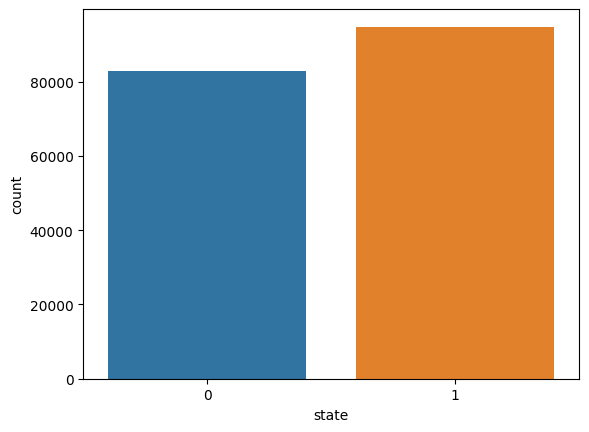

In [ ]:
#check how balanced our dataset is
vs.countplot(df_kick, "state")

Out dataset is only slightly unbalaced with approx. 53% of the data being in state 1

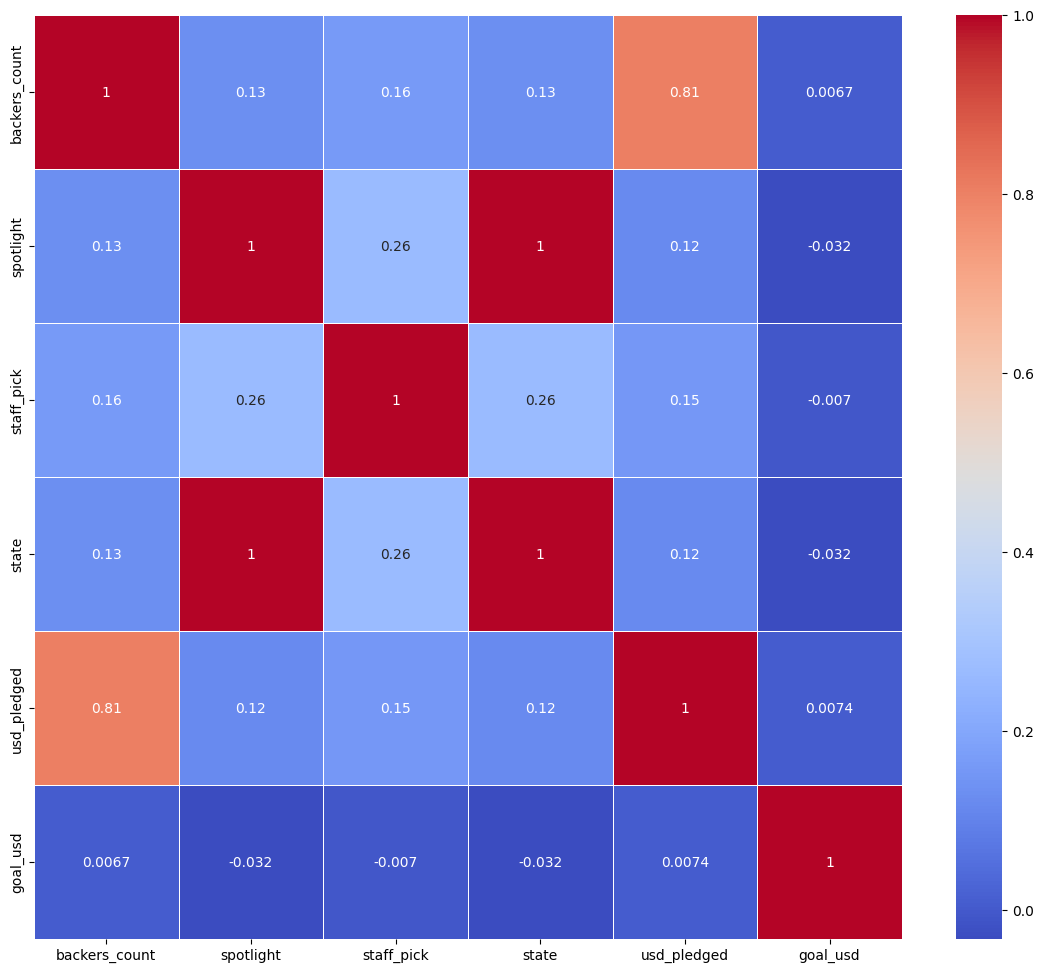

In [ ]:
vs.corr_map(df_kick.drop("disable_communication",axis=1))

The features splotlight and state are 100% correlated. Hence, we drop spotlight.

In addition, usd_pledged and backers_count are highly correlated as well. This makes sense. We will only use one of these two features for the models

In [ ]:
df_kick = df_kick.drop("spotlight", axis=1) 

## Baseline Model
Our baseline model is to simply predict the positive outcome (state=successful) by the value of the goal in USD. As the threshold we choose the mean of all goal_usd values which is 5000$.

Baseline :
Accuracy: 0.5955980473302815
Recall: 0.5729222718112662
Precision: 0.634016766690797


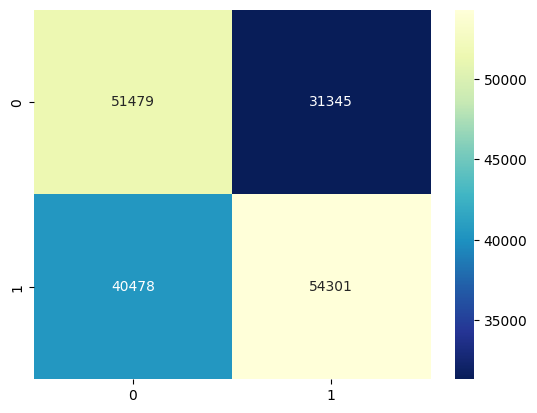

In [ ]:
y_pred_baseline = mod.baseline(df_kick,"goal_usd",5000)
mod.eval_metrics(df_kick.state, y_pred_baseline, "Baseline")

So our very basic model is already better than randomly guessing. We chose precision as our main evaluation metric since our stakeholder in interested in accurate information about the probability of success. Our baseline model has a precision of 63%.

Now we try a model that is a little more complex, but still very simple. The model consists of a logistic regression with only one feature.

In [ ]:
y = df_kick.state
X_simple = df_kick[["backers_count"]]
X_train_simple, X_test_simple, y_train, y_test = train_test_split(X_simple, y, test_size = 0.2, random_state = 0)

y_pred_simple = mod.simple_model(X_train_simple, y_train, X_test_simple)
mod.eval_metrics(y, y_pred_simple, "Linear Regression")


The simple model based on backers_count has a precision of 75%.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier




## Preprocessing

In [ ]:
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import json
import re


df_kick.info()

In [ ]:
num_features = ["backers_count", "goal_usd"]
cat_features = ["category_clean", "country"]

df_kick.creator

In [ ]:
df_kick["category_clean"] = [re.sub("/.*","", json.loads(entry)["slug"]) for entry in df_kick.category ]
df_kick.category_clean.nunique()

df_kick["creator_clean"] = [json.loads(re.sub(",.*" , "}", entry))["id"] for entry in df_kick.creator ]
df_kick.creator_clean.value_counts()



In [ ]:
# Pipline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)
num_pipeline = Pipeline([
    #('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    #('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
#from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [ ]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [ ]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

In [ ]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforest', RandomForestClassifier())
])

In [ ]:
temp  = cat_features + num_features

X = df_kick[temp]

y = df_kick["state"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
pipe_logreg.fit(X_test, y_test)
y_train_predicted_logreg = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)

pipe_knn.fit(X_test, y_test)
y_train_predicted_knn = cross_val_predict(pipe_knn, X_train, y_train, cv=5)

pipe_random_forest.fit(X_test, y_test)
y_train_predicted_random_forest = cross_val_predict(pipe_random_forest, X_train, y_train, cv=5)


In [ ]:
y_pred_log_reg = pipe_logreg.predict(X_test)
y_pred_knn = pipe_knn.predict(X_test)
y_pred_random_forest = pipe_random_forest.predict(X_test)

In [ ]:
print("precision score log reg", precision_score(y_test, y_pred_log_reg))
print("precision score knn", precision_score(y_test, y_pred_knn))
print("precision score random forest", precision_score(y_test, y_pred_random_forest))

In [ ]:
# Defining parameter space for grid-search. Since we want to access the classifier step (called 'logreg') in our pipeline 
# we have to add 'logreg__' infront of the corresponding hyperparameters. 
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)



param_knn = {'knn__n_neighbors': [5, 10, 20, 40],
             'knn__p': [1, 2]}

grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)



param_random_forest = {'random_forest__n_estimators' : [50, 100, 150, 200],
            'random_forest__criterion': ['gini', 'entropy'],
            'random_forest__min_samples_leaf': [1, 5, 25, 125, 625],
            'random_forest__max_depth': [None, 10, 20, 30, 50]
               }

grid_random_forest = GridSearchCV(pipe_random_forest, param_grid=param_random_forest, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

In [ ]:
grid_logreg.fit(X_train, y_train)

In [ ]:
grid_knn.fit(X_train, y_train)

In [ ]:
grid_random_forest.fit(X_train, y_train)

In [ ]:
# Show best parameters
print('Best score logreg:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters logreg:\n{}".format(grid_logreg.best_params_))
#print('Best score knn:\n{:.2f}'.format(grid_knn.best_score_))
#print("Best parameters knn:\n{}".format(grid_knn.best_params_))
#print('Best score random forest:\n{:.2f}'.format(grid_random_forest.best_score_))
#print("Best parameters random forest:\n{}".format(grid_random_forest.best_params_))

In [ ]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model_logreg = grid_logreg.best_estimator_
best_model_knn = grid_knn.best_estimator_
best_model_random_forest = grid_random_forest.best_estimator_


In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted_logreg = best_model_logreg.predict(X_test)
y_test_predicted_knn = best_model_knn.predict(X_test)
y_test_predicted_random_forest = best_model_random_forest.predict(X_test)


print("Accuracy logreg: {:.2f}".format(accuracy_score(y_test, y_test_predicted_logreg)))
print("Recall logreg: {:.2f}".format(recall_score(y_test, y_test_predicted_logreg)))
print("Precision logreg: {:.2f}".format(precision_score(y_test, y_test_predicted_logreg)))
print("Accuracy knn: {:.2f}".format(accuracy_score(y_test, y_test_predicted_knn)))
print("Recall knn: {:.2f}".format(recall_score(y_test, y_test_predicted_knn)))
print("Precision knn: {:.2f}".format(precision_score(y_test, y_test_predicted_knn)))
print("Accuracy random forest: {:.2f}".format(accuracy_score(y_test, y_test_predicted_random_forest)))
print("Recall random forest: {:.2f}".format(recall_score(y_test, y_test_predicted_random_forest)))
print("Precision random forest: {:.2f}".format(precision_score(y_test, y_test_predicted_random_forest)))